In [64]:
import numpy as np
import matplotlib.pyplot as plt

# particula imports
from particula.next import particles
from particula.next.aerosol import Aerosol

from particula.next.gas.species_builders import PresetGasSpeciesBuilder
from particula.next.gas.atmosphere_builders import AtmosphereBuilder

from particula.next.dynamics import particle_process
from particula.next.dynamics import coagulation

from particula.util.input_handling import convert_units


In [65]:
# common parameters
mode = np.array([100e-9])
geometric_standard_deviation = np.array([1.3])
number_of_particles = np.array([1])  # effective when pdf has multiple modes
density = np.array([1.0e3])
volume = 0.1 * convert_units('cm^3', 'm^3')  # cm^-3 to m^-3

# Preset gas species that does not condense in the atmosphere
# AtmosphereBuilder constructs the atmosphere with predefined species
atmosphere = (
    AtmosphereBuilder()
    .add_species(PresetGasSpeciesBuilder().build())  # Add a preset gas species
    .set_temperature(25, temperature_units="degC")  # Set temperature to 25°C
    .set_pressure(1, pressure_units="atm")  # Set pressure to 1 atmosphere
    .build()  # Finalize the atmosphere object
)

In [66]:
number_of_samples = 100_000  # Number of samples for particle distribution

# Generate a particle distribution using a lognormal sample distribution
# This distribution has a mean particle diameter (mode) and geometric standard deviation (GSD)
radii_sample= particles.properties.lognormal_sample_distribution(
    mode=mode,
    geometric_standard_deviation=geometric_standard_deviation,
    number_of_particles=number_of_particles,
    number_of_samples=number_of_samples,  # Number of samples for particle distribution
)

# Calculate the mass of each particle in the sample, assuming density of 1500 kg/m^3
particle_mass_sample = (
    4 / 3 * np.pi * radii_sample**3 * density
)  # Particle mass in kg

print(f"Total mass of particles: {np.sum(particle_mass_sample):.2e} kg")
# Build a resolved mass representation for each particle
# This defines how particle mass, activity, and surface are represented
resolved_masses = (
    particles.ResolvedParticleMassRepresentationBuilder()
    # Use specieated mass distribution, ideal mass activity, and volume surface strategy
    .set_distribution_strategy(particles.ParticleResolvedSpeciatedMass())
    .set_activity_strategy(particles.ActivityIdealMass())
    .set_surface_strategy(particles.SurfaceStrategyVolume())
    .set_mass(particle_mass_sample, "kg")  # Assign mass of particles (in kg)
    .set_density(density, "kg/m^3")  # Set particle density
    .set_charge(0)  # Assume neutral particles with no charge
    .set_volume(volume)  # Set volume of particle distribution
    .build()  # Finalize the resolved mass representation
)

# Create an aerosol object with the defined atmosphere and resolved particles
aerosol_resolved = Aerosol(atmosphere=atmosphere, particles=resolved_masses)

# Print the properties of the aerosol
print(aerosol_resolved)

Total mass of particles: 5.68e-13 kg
Gas mixture at 298.15 K and 101325.0 Pa consisting of ['Preset100']
[0]: Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityIdealMass
	Surface: SurfaceStrategyVolume
	Mass Concentration: 5.684e-06 [kg/m^3]


In [67]:
# Build a resolved mass representation for each particle
# This defines how particle mass, activity, and surface are represented
radius_bins = np.logspace(-8, -6, 200)  # Define the radius bins for the resolved mass representation

number_concentration = np.array([number_of_samples/volume])  # Calculate the number concentration of particles
print(f"Number concentration: {number_concentration[0]:.2e} m^-3")
particle_pmf = (
    particles.PresetParticleRadiusBuilder()
    .set_mode(mode)
    .set_geometric_standard_deviation(geometric_standard_deviation)
    .set_number_concentration(number_concentration)
    .set_distribution_type('pmf')  # Set the distribution type to PMF
    .set_radius_bins(radius_bins, radius_bins_units="m")  # Set the radius bins
    .set_density(density, "kg/m^3")  # Set particle density
    .build()  # Finalize the resolved mass representation
)

# Create an aerosol object with the defined atmosphere and resolved particles
aerosol_pmf = Aerosol(atmosphere=atmosphere, particles=particle_pmf)

# Print the properties of the aerosol
print(aerosol_pmf)


Number concentration: 1.00e+12 m^-3
Gas mixture at 298.15 K and 101325.0 Pa consisting of ['Preset100']
[0]: Particle Representation:
	Strategy: RadiiBasedMovingBin
	Activity: ActivityIdealMass
	Surface: SurfaceStrategyVolume
	Mass Concentration: 5.710e-06 [kg/m^3]


In [68]:
particle_pdf = (
    particles.PresetParticleRadiusBuilder()
    .set_mode(mode)
    .set_geometric_standard_deviation(geometric_standard_deviation)
    .set_number_concentration(number_concentration)
    .set_distribution_type("pdf")  # Set the distribution type to PMF
    .set_radius_bins(radius_bins, radius_bins_units="m")  # Set the radius bins
    .set_density(density, "kg/m^3")  # Set particle density
    .set_charge(np.zeros_like(radius_bins))  # Assume neutral particles with no charge
    .build()  # Finalize the resolved mass representation
)

# Create an aerosol object with the defined atmosphere and resolved particles
aerosol_pdf = Aerosol(atmosphere=atmosphere, particles=particle_pdf)

# Print the properties of the aerosol
print(aerosol_pdf)

Gas mixture at 298.15 K and 101325.0 Pa consisting of ['Preset100']
[0]: Particle Representation:
	Strategy: RadiiBasedMovingBin
	Activity: ActivityIdealMass
	Surface: SurfaceStrategyVolume
	Mass Concentration: 2.077e+03 [kg/m^3]


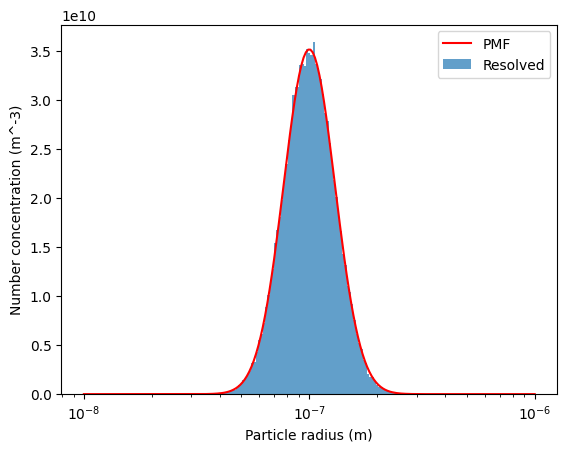

In [69]:
# plot both
radius_bins = particle_pmf.get_radius()
radii_resolved = resolved_masses.get_radius()

fig, ax = plt.subplots()
bins, edges = np.histogram(radii_resolved, bins=radius_bins)
ax.bar(
    edges[:-1],
    bins/volume,
    width=np.diff(edges),
    align="edge",
    label="Resolved",
    alpha=0.7,
)
ax.plot(
    radius_bins,
    particle_pmf.get_concentration(),
    label="PMF",
    color="red",
)
ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel("Number concentration (m^-3)")
ax.legend()
plt.show()

In [70]:
# simulate both aerosols, and save total mass and number distribution

# Define the coagulation process
coagulation_process_pmf = particle_process.Coagulation(
    coagulation_strategy=coagulation.DiscreteSimple()
)
coagulation_process_resolved = particle_process.Coagulation(
    coagulation_strategy=coagulation.ParticleResolved(kernel_bins_number=50)
)
hard_sphere = coagulation.HardSphere()
coagulation_process_pdf = particle_process.Coagulation(
    coagulation_strategy=coagulation.ContinuousGeneralPDF(hard_sphere)
)

# Set up time and sub-steps for the coagulation process
total_time = 5000
time_step = 100
sub_steps = 5

# output arrays
time = np.arange(0, total_time, time_step)
total_mass_pmf = np.zeros_like(time, dtype=np.float64)
total_mass_resolved = np.ones_like(time, dtype=np.float64)
total_mass_pdf = np.zeros_like(time, dtype=np.float64)
number_distribution_pmf = np.zeros((len(time), len(radius_bins)))
number_distribution_resolved = np.zeros((len(time), number_of_samples))
number_distribution_pdf = np.zeros((len(time), len(radius_bins)))
total_number_pmf = np.zeros_like(time, dtype=np.float64)
total_number_resolved = np.ones_like(time, dtype=np.float64)
total_number_pdf = np.zeros_like(time, dtype=np.float64)


In [71]:
# Simulation loop

for i, t in enumerate(time):
    if i > 0:
        # Perform coagulation for the PDF aerosol
        aerosol_pdf = coagulation_process_pdf.execute(aerosol_pdf, time_step, sub_steps)
        # Perform coagulation for the PMF aerosol
        aerosol_pmf = coagulation_process_pmf.execute(aerosol_pmf, time_step, sub_steps)
        # Perform coagulation for the resolved aerosol
        aerosol_resolved = coagulation_process_resolved.execute(aerosol_resolved, time_step, sub_steps)

    total_mass_resolved[i] = aerosol_resolved.particles[0].get_total_mass()
    number_distribution_resolved[i, :] = aerosol_resolved.particles[0].get_radius(clone=True)
    total_number_resolved[i] = np.sum(number_distribution_resolved[i, :]>0)

    total_mass_pmf[i] = aerosol_pmf.particles[0].get_total_mass()
    number_distribution_pmf[i, :] = aerosol_pmf.particles[0].get_concentration(clone=True)
    total_number_pmf[i] = np.sum(number_distribution_pmf[i, :])

    total_mass_pdf[i] = aerosol_pdf.particles[0].get_total_mass()
    number_distribution_pdf[i, :] = aerosol_pdf.particles[0].get_concentration(clone=True)
    total_number_pdf[i] = np.trapz(number_distribution_pdf[i, :], radius_bins)

print(aerosol_resolved)
print(aerosol_pmf)
print(aerosol_pdf)

Gas mixture at 298.15 K and 101325.0 Pa consisting of ['Preset100']
[0]: Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityIdealMass
	Surface: SurfaceStrategyVolume
	Mass Concentration: 4.911e-06 [kg/m^3]
Gas mixture at 298.15 K and 101325.0 Pa consisting of ['Preset100']
[0]: Particle Representation:
	Strategy: RadiiBasedMovingBin
	Activity: ActivityIdealMass
	Surface: SurfaceStrategyVolume
	Mass Concentration: 5.551e-06 [kg/m^3]
Gas mixture at 298.15 K and 101325.0 Pa consisting of ['Preset100']
[0]: Particle Representation:
	Strategy: RadiiBasedMovingBin
	Activity: ActivityIdealMass
	Surface: SurfaceStrategyVolume
	Mass Concentration: 1.347e+03 [kg/m^3]


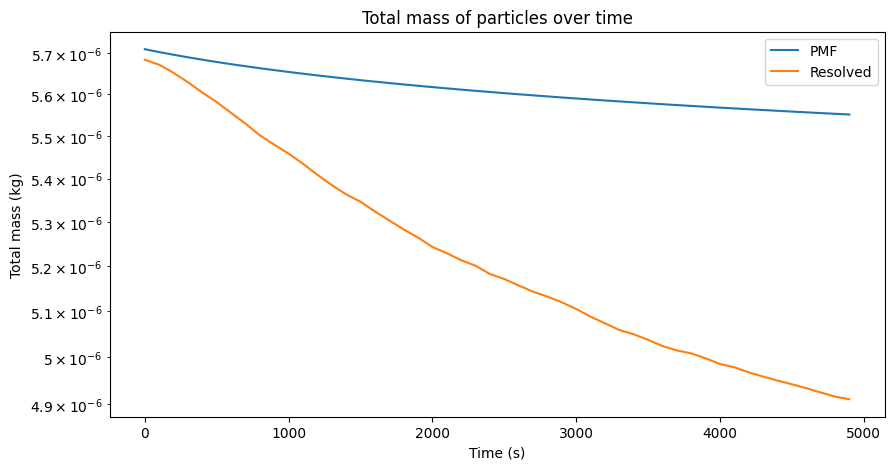

In [72]:
# plot results
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(time, total_mass_pmf, label="PMF")
ax.plot(time, total_mass_resolved/volume, label="Resolved")
# ax.plot(time, total_mass_pdf, label="PDF")

ax.set_yscale("log")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Total mass (kg)")
ax.set_title("Total mass of particles over time")
ax.legend()
plt.show()

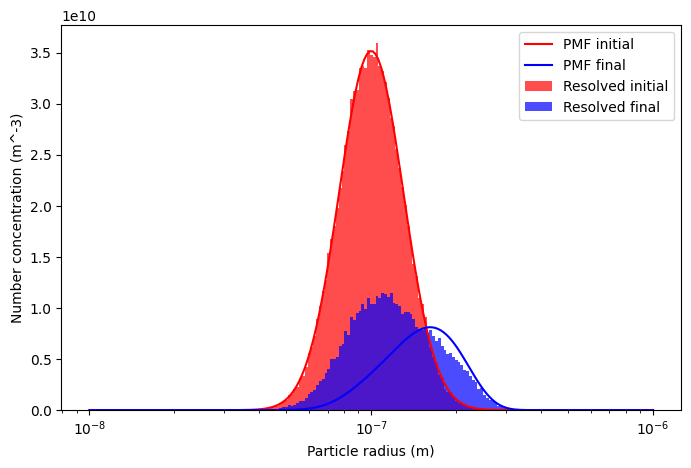

In [73]:
# plot the initial and final distributions
fig, ax = plt.subplots(figsize=(8, 5))

bins, edges = np.histogram(
    number_distribution_resolved[0, :], bins=radius_bins
)
ax.bar(
    edges[:-1],
    bins / volume,
    width=np.diff(edges),
    align="edge",
    label="Resolved initial",
    color="red",
    alpha=0.7,
)
bins, edges = np.histogram(
    number_distribution_resolved[-1, :], bins=radius_bins
)
ax.bar(
    edges[:-1],
    bins / volume,
    width=np.diff(edges),
    align="edge",
    label="Resolved final",
    color="blue",
    alpha=0.7,
)

ax.plot(radius_bins, number_distribution_pmf[0, :], label="PMF initial", color="red")
ax.plot(radius_bins, number_distribution_pmf[-1, :], label="PMF final", color="blue")

ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel("Particle radius (m)")
ax.set_ylabel("Number concentration (m^-3)")
ax.legend()
plt.show()

Total particles at end of simulation: 44483
Gas mixture at 298.15 K and 101325.0 Pa consisting of ['Preset100']
[0]: Particle Representation:
	Strategy: ParticleResolvedSpeciatedMass
	Activity: ActivityIdealMass
	Surface: SurfaceStrategyVolume
	Mass Concentration: 4.911e-06 [kg/m^3]
Gas mixture at 298.15 K and 101325.0 Pa consisting of ['Preset100']
[0]: Particle Representation:
	Strategy: RadiiBasedMovingBin
	Activity: ActivityIdealMass
	Surface: SurfaceStrategyVolume
	Mass Concentration: 5.551e-06 [kg/m^3]


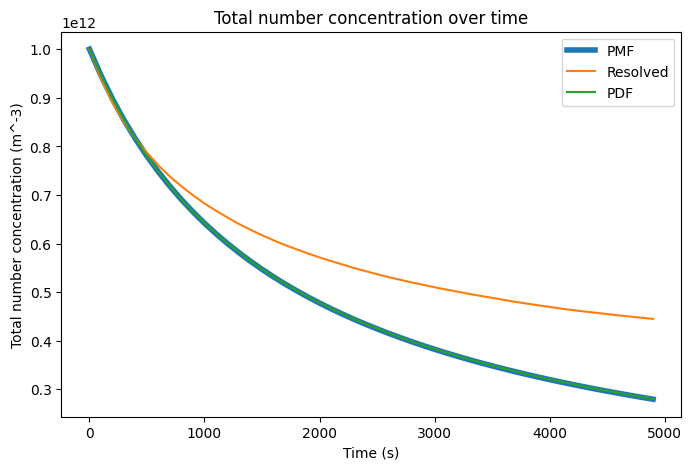

In [74]:
# sum number concentration and plot

total_pmf = np.sum(number_distribution_pmf, axis=1)
total_resolved_non_zero = number_distribution_resolved > 0
total_resolved = np.sum(total_resolved_non_zero, axis=1) / volume
print(
    f"Total particles at end of simulation: {np.sum(total_resolved_non_zero[-1, :])}"
)
print(aerosol_resolved)
print(aerosol_pmf)

percent_diff = (total_pmf - total_resolved) / total_pmf * 100

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(time, total_pmf, label="PMF", linewidth=4)
ax.plot(time, total_resolved, label="Resolved")
ax.plot(time, total_number_pdf, label="PDF")
# ax.plot(time, percent_diff, label="Percent difference")
# ax.set_yscale("log")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Total number concentration (m^-3)")
ax.set_title("Total number concentration over time")
ax.legend()
plt.show()